# Trabalho 3 - Machine Learning II - Deep Learning
Prof: Carlos Padilha

#### Alunos:  

Roberto A. Coutinho  
Thais Galho

**Enunciado**

1.  Introdução a Deep Learning
    Este trabalho visa avaliar o entendimento em relação as redes convolutivas e recorrentes vistas em sala para resolver diversos problemas.  
    
    
2.  A proposta é que a dupla escolha alguma aplicação que mais se interessa e resolva usando os conceitos vistos em sala. Segue alguns exemplos de problemas que vocês podem escolher:

    * Classificação de imagens
    * Geração automática de imagens • Reconstrução de imagens
    * Análise de sentimento
    * Sumarização de textos
    * Predição em séries temporais

Obs. Importante lembrar que é desejado que vocês escolham bases de dados diferentes daquelas usadas em sala.
O trabalho pode ser feito em dupla e deve ser enviado por email (carlos.engcomp@gmail.com).

**Descrição da proposta de trabalho**

1. Decidimos utilizar redes neurais convolutivas para classificação multi-classe de imagens de flores.  

    "No contexto de inteligência artificial e aprendizagem de máquina, uma rede neural convolucional é uma classe de rede neural artificial do tipo feed-forward, que vem sendo aplicada com sucesso no processamento e análise de imagens digitais"
        Fonte: Wikipédia


2. Como otimizador usamos o Gradiente Descendente Estocástico  


3. Dataset Flowers
    * Classes: Tulipas, Dentes de Leão, Rosas, Girassóis e Margaridas


4. Usamos o Dataset e ambiente de treinamento do Kaggle.
    * GPU on
    * Tensorflow + Keras


## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the Keras libraries and packages
from keras.optimizers import *
from keras.metrics import *
from keras.callbacks import *
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from tensorflow.contrib.keras.api.keras.callbacks import Callback
from tensorflow.contrib.keras.api.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras import backend

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

script_dir = os.path.dirname(".")
training_set_path = os.path.join(script_dir, '../input/flowers/flowers/')
test_set_path = os.path.join(script_dir, '../input/flowers/flowers/')

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['flowers']


## Leitura dos datasets de treinamento e teste

    * Batch Size : 32
    * Input Size : 256x256 

In [2]:
batch_size = 32
input_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255, 
                                  validation_split=0.33)

### Separação de treinamento

In [3]:
training_set = train_datagen.flow_from_directory(training_set_path,
                                                 target_size=input_size,
                                                 batch_size=batch_size,
                                                 subset="training",
                                                 class_mode='categorical')

Found 4323 images belonging to 5 classes.


### Separação de teste

In [4]:
test_set = test_datagen.flow_from_directory(test_set_path,
                                            target_size=input_size,
                                            batch_size=batch_size,
                                            subset="validation",
                                            class_mode='categorical',
                                            shuffle=False)

Found 1424 images belonging to 5 classes.


# Definição da Arquitetura da Rede Neural Convolutiva

Nessa seção é criada a arquitetura da CNN usando Keras e Tensorflow

    - Obs: Essa arquitetura foi inspirada em exemplos do Kaggle.

### Definição de arquitetura sequencial

In [5]:
cnn = Sequential()

#### Primeira camada convolutiva

    * Na primeira camada é preciso setar o input_shape. Nas outras isso é feito por inferência.

In [6]:
cnn.add(Conv2D(32, 
              (3, 3), 
              input_shape=(256,256,3), 
              activation='relu'))

cnn.add(MaxPooling2D(pool_size=(2, 2), 
                     data_format="channels_first"))

#### Segunda camada convolutiva

In [7]:
cnn.add(Conv2D(32, 
              (3, 3), 
              activation='relu'))

cnn.add(MaxPooling2D(pool_size=(2, 2)))

#### Terceira camada convolutiva

In [8]:
cnn.add(Conv2D(64, 
              (3, 3), 
              activation='relu'))

cnn.add(MaxPooling2D(pool_size=(2, 2)))

#### Flattening

    * Flattening converte o vetor 2d em um vetor de uma dimensão para apresentar à rede.

In [9]:
cnn.add(Flatten())

#### Camada Full Connection
    * 64 neurônios
    * Função de ativação ReLU

In [10]:
cnn.add(Dense(units=64, 
              activation='relu'))

#### Dropout

    * Aplica a técnica de dropout, método de regularização que reduz o overfitting em redes neurais. 

In [11]:
cnn.add(Dropout(0.5))

#### Camada Full Connection
    * 5 Neurônios de saida (Um neurônio para cada classe)
    * Função de ativação Softmax

In [12]:
cnn.add(Dense(units=5, 
              activation='softmax'))

### Definição da função de callback

Essa função é utilizada para mostrar a evolução do treinamento entre as épocas, apresentado a acurácia atual versus a acurácia de validação para cada época de treinamento.

In [14]:
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_id = 0
        self.losses = ''

    def on_epoch_end(self, epoch, logs={}):
        self.losses += "Epoch {}: accuracy -> {:.4f}, val_accuracy -> {:.4f}\n"\
            .format(str(self.epoch_id), logs.get('acc'), logs.get('val_acc'))
        self.epoch_id += 1

    def on_train_begin(self, logs={}):
        self.losses += 'Iniciando treinamento...\n'
        
history = LossHistory()

class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

acc_history = AccuracyHistory()

In [15]:
# Declarado mas não usado, pois não melhora o desempenho.
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5)

###  Definição da função de otimização Gradiente Descendente Estocástico

In [16]:
optim = SGD(lr=0.01, 
          momentum=0.0, 
          decay=0.0, 
          nesterov=False)

## Compilação do modelo

Aqui é compilado a arquitetura usando como função de perda a crossentropia categorica, o otimizador SGD e a métrica de acurácia.

In [17]:
cnn.compile(optimizer=optim, 
           loss='categorical_crossentropy', 
           metrics=['accuracy'])

## Execução do treinamento

In [18]:
cnn.fit_generator(training_set,
                 steps_per_epoch=1000/batch_size,
                 epochs=90,
                 validation_data=test_set,
                 validation_steps=100/batch_size,
                 workers=24,
                 callbacks=[history, acc_history])

Epoch 1/90
32/31 [==============================] - 24s 756ms/step - loss: 1.5923 - acc: 0.2598 - val_loss: 1.3633 - val_acc: 0.8594
Epoch 2/90
32/31 [==============================] - 22s 675ms/step - loss: 1.5325 - acc: 0.3115 - val_loss: 1.7721 - val_acc: 0.2656
Epoch 3/90
32/31 [==============================] - 21s 671ms/step - loss: 1.4670 - acc: 0.3525 - val_loss: 1.3203 - val_acc: 0.2109
Epoch 4/90
32/31 [==============================] - 21s 661ms/step - loss: 1.4014 - acc: 0.3770 - val_loss: 1.2582 - val_acc: 0.4375
Epoch 5/90
32/31 [==============================] - 19s 605ms/step - loss: 1.3902 - acc: 0.3936 - val_loss: 1.3827 - val_acc: 0.2812
Epoch 6/90
32/31 [==============================] - 20s 619ms/step - loss: 1.3062 - acc: 0.4199 - val_loss: 1.6753 - val_acc: 0.0703
Epoch 7/90
32/31 [==============================] - 20s 613ms/step - loss: 1.2491 - acc: 0.4893 - val_loss: 0.9630 - val_acc: 0.6562
Epoch 8/90
32/31 [==============================] - 19s 604ms/step - 

# Apresentação dos Resultados

  
  
Nessa seção são apresentados os resultados da execução do treinamento usando Redes Neurais Convolutivas para classficação múltipla no dataset sobre imagens Flores.

In [20]:
score = cnn.evaluate_generator(test_set, 45)
print(score)

[0.7664623615447055, 0.6931179775280899]


In [21]:
validation_set = test_datagen.flow_from_directory(test_set_path,
                                            target_size=input_size,
                                            batch_size=batch_size,
                                            subset="validation",
                                            class_mode='categorical',
                                            shuffle=False)

Found 1424 images belonging to 5 classes.


### Predição da validação

Predição da amostragem destinada a validação

In [22]:
Y_pred = cnn.predict_generator(validation_set, 45)
y_pred = np.argmax(Y_pred, axis=1)

### Acurácia

Apresentação da acurácia na amostragem de validação

In [23]:
accuracy_score(validation_set.classes, y_pred)

0.6931179775280899

 ### Matriz de confusão

Apresentação da matriz de confusáo da classificação da amostragem de validação

In [24]:
print(confusion_matrix(validation_set.classes,y_pred))

[[143  74  10  10  16]
 [  3 313   1  20  10]
 [  7  38 105   6 102]
 [  5  43   0 185   9]
 [  4  38  20  21 241]]


### Plotagem da acurácia X épocas


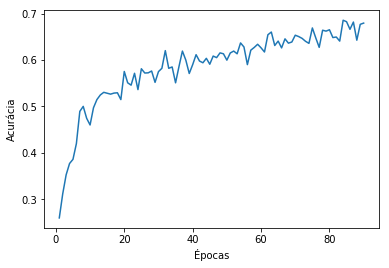

In [28]:
import matplotlib.pylab as plt

plt.plot(range(1, 91), acc_history.acc)
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()

# Conclusões Finais

Observando através de diversas execuções do treinamento no Kernel do Kaggle para tirar vantagem do uso da GPU, podemos concluir que a arquitetura proposta obteve uma acurácia de 71% usando como otimizador o Gradiente Descendente Estocástico.

Para se obter melhores resultados, podemos utilizar outros otimizadores como, por exemplo, o Adam. Entretanto, há também inúmeras oportunidades de alterar os hyper-paramêtros da rede, bem como adicionar ou remover camadas convolutivas. Porém, esses testes demandam mais tempo e validação para se obter um modelo com melhores métricas.

Mas de forma geral, a CNN conseguiu generalizar o problema e obteve resultado satisfatório, sendo que a quinta classe foi a que demonstrou pior performance, e nesse caso, pode-se aplicar técnicas de pré-processamento ou pesos a fim de melhorar especificamente para essa determinada classe um melhor desempenho de classificação.